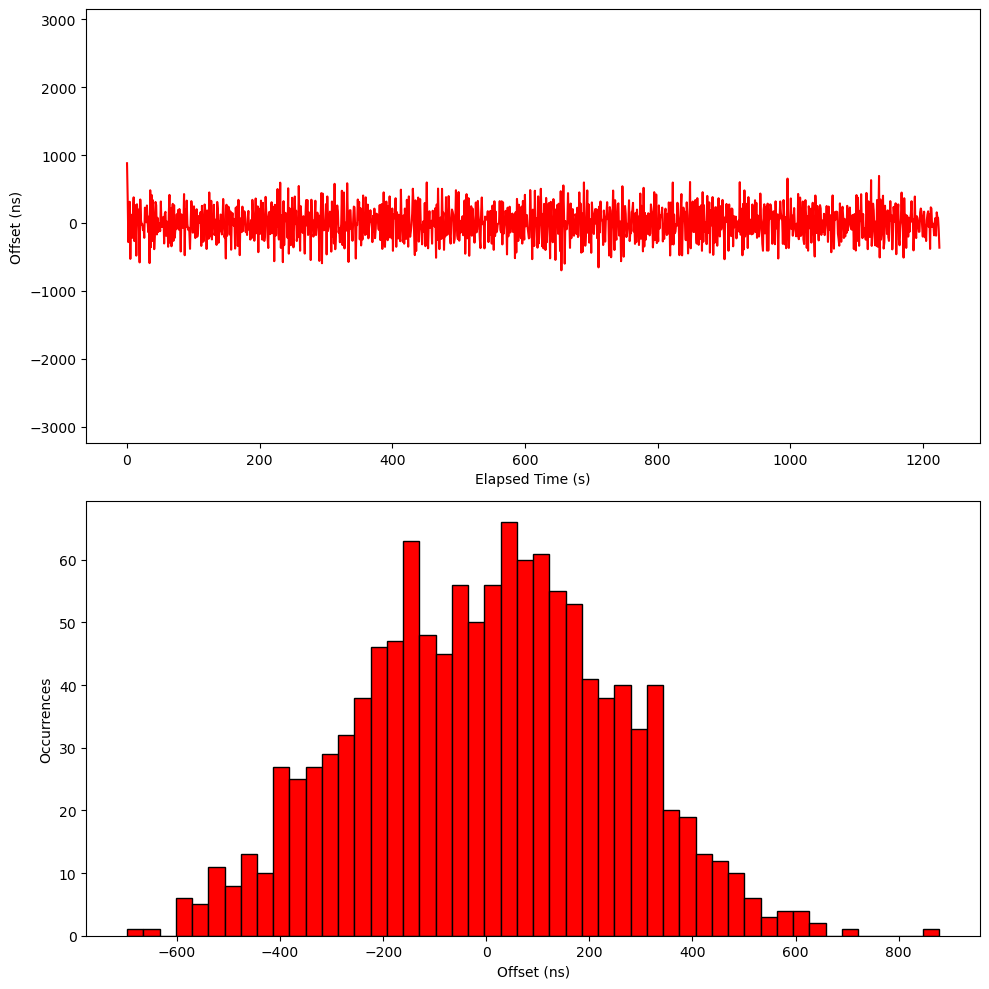

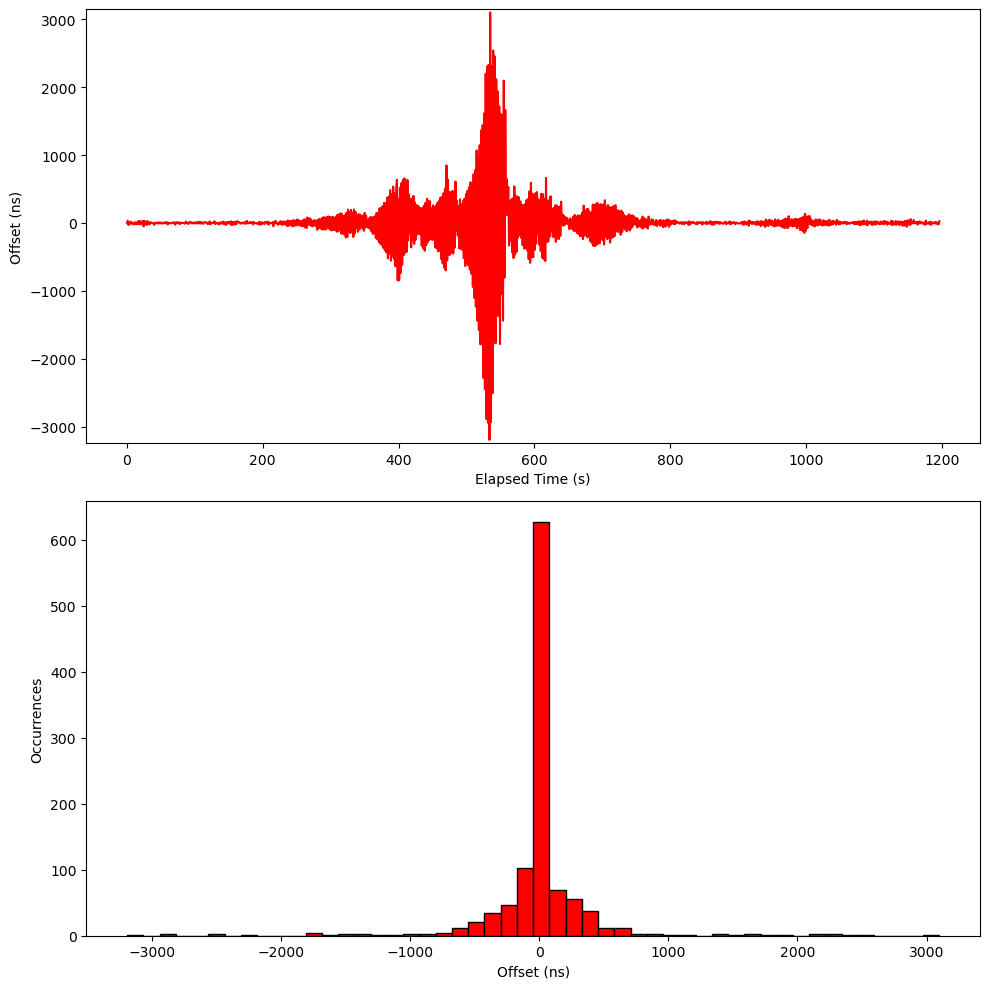

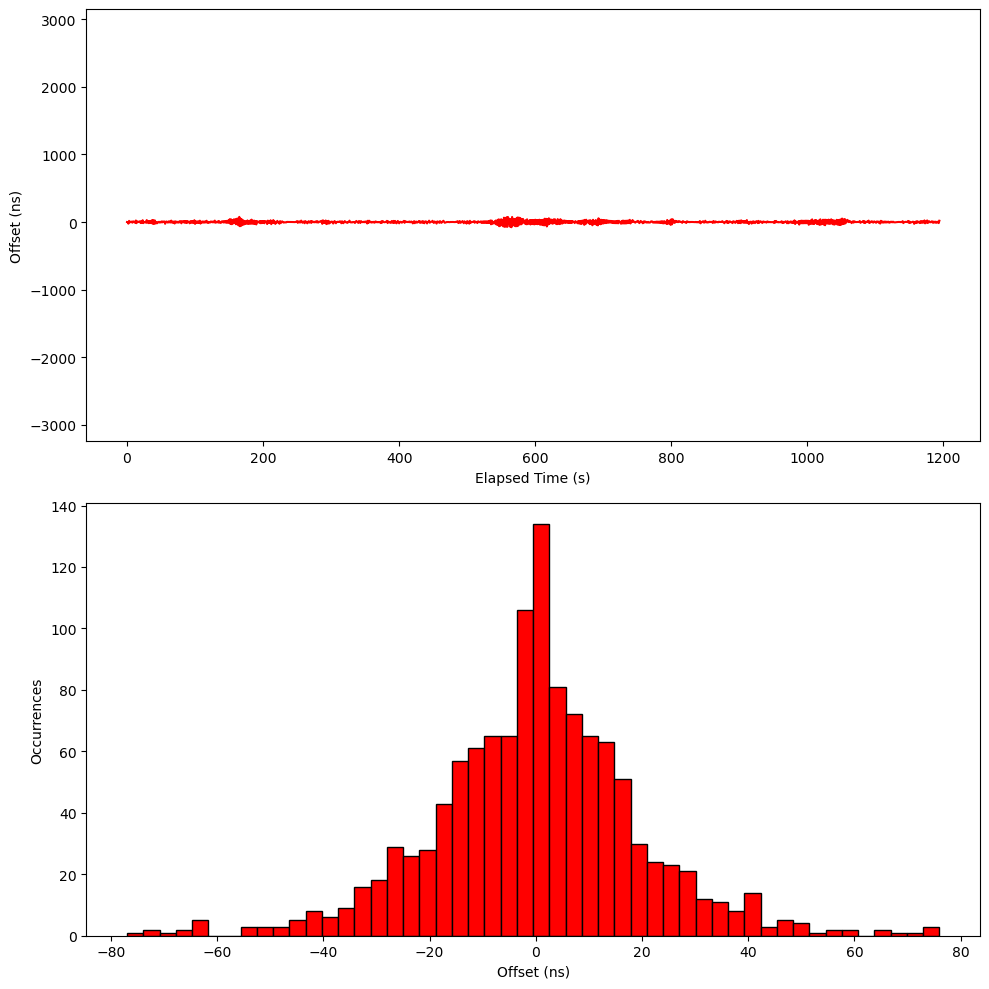

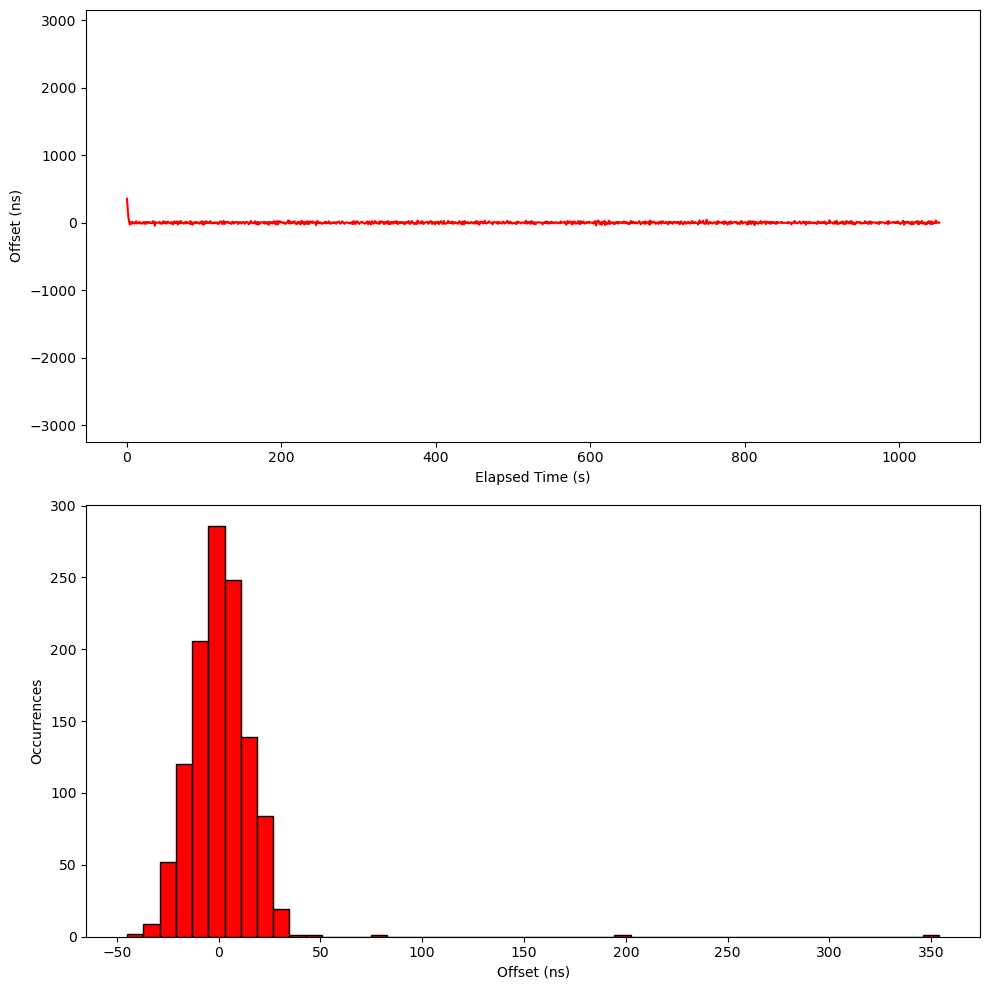

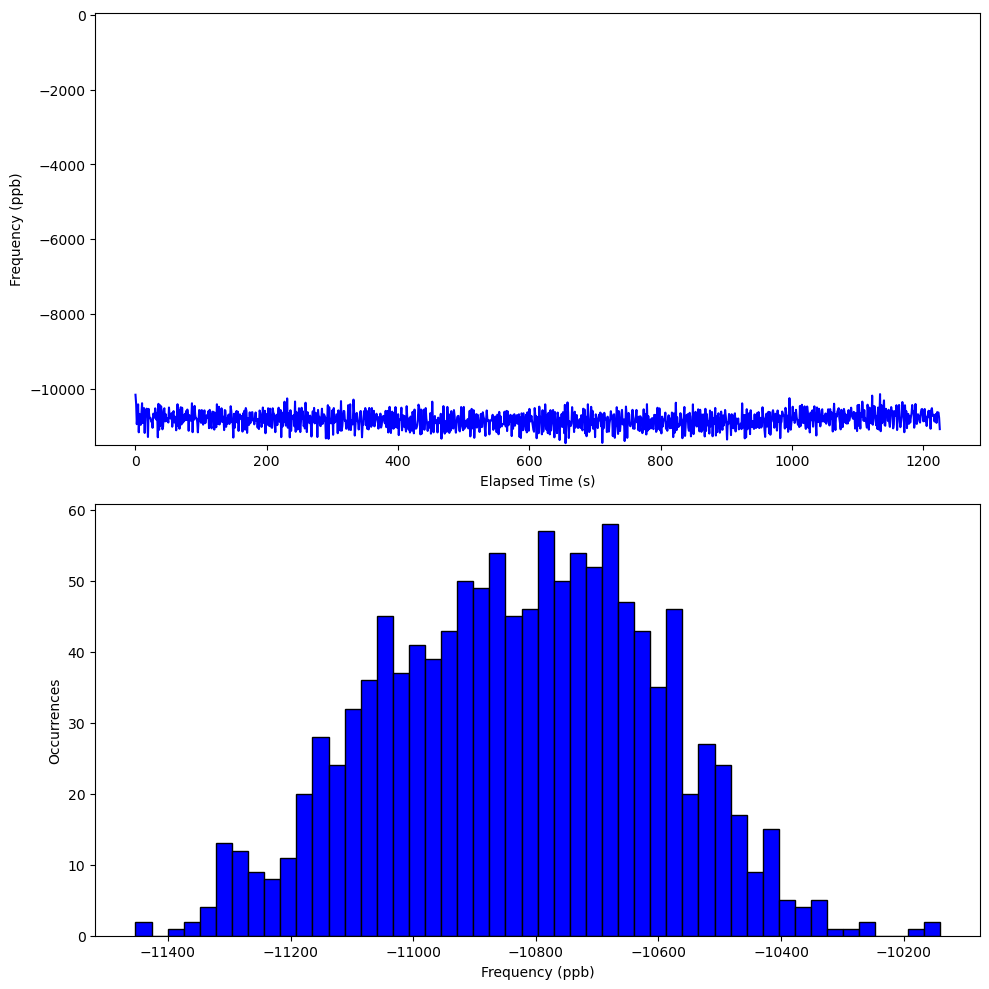

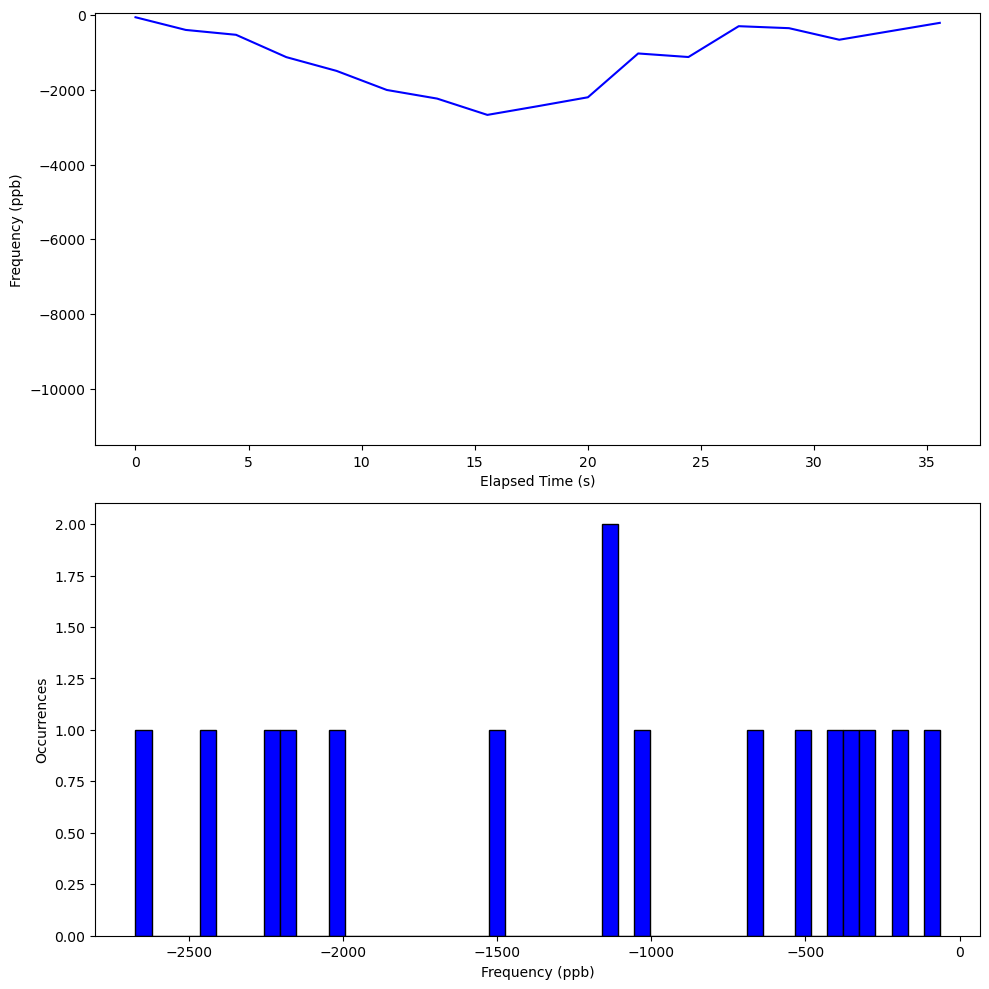

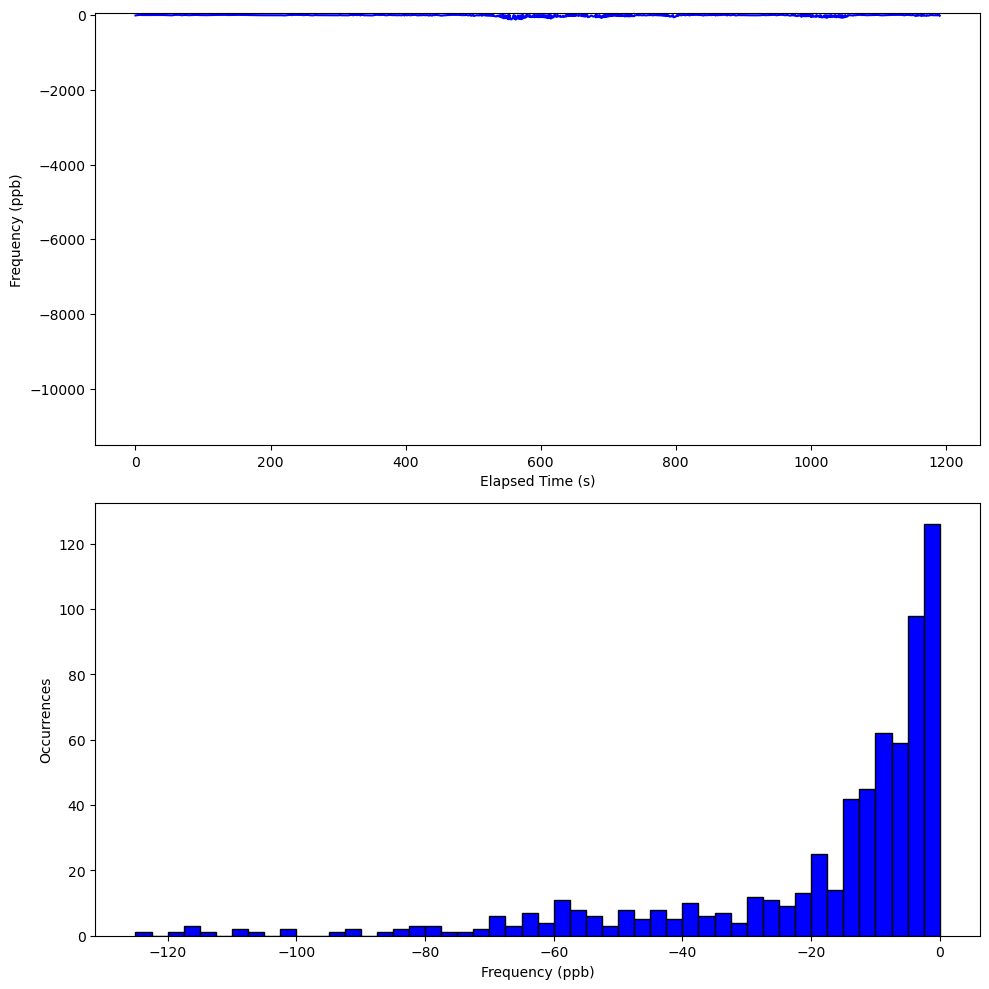

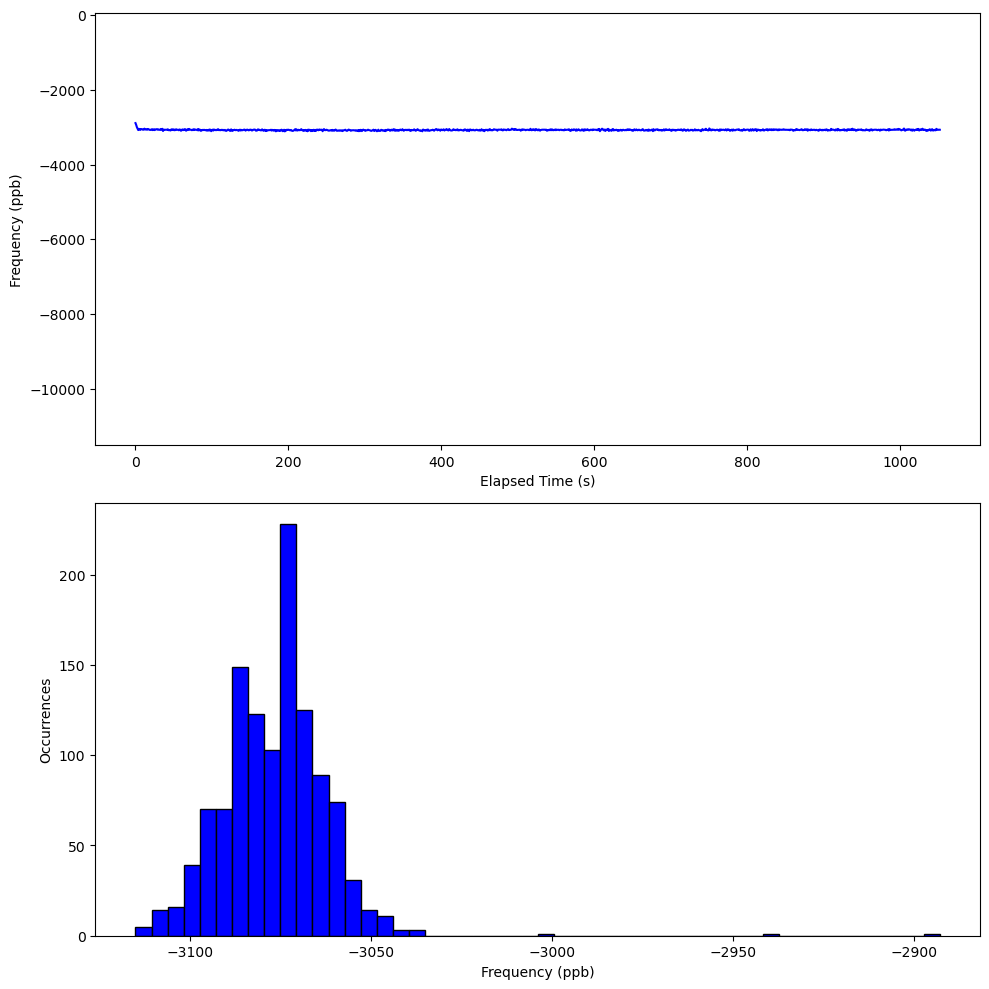

In [29]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

# Function to process log files
def process_log_file(log_file, pattern):
    with open(log_file, 'r') as file:
        log_data = file.read()
    data = re.findall(pattern, log_data)
    df = pd.DataFrame(data, columns=['elapsed_time', 'value'])
    df['elapsed_time'] = pd.to_numeric(df['elapsed_time'])
    df['value'] = pd.to_numeric(df['value'])
    df['seconds'] = df['elapsed_time'] - df['elapsed_time'].iloc[0]
    return df

# Function to determine global limits
def determine_global_limits(log_files, pattern):
    global_min = float('inf')
    global_max = float('-inf')
    for log_file in log_files:
        df = process_log_file(log_file, pattern)
        min_val = df['value'].min()
        max_val = df['value'].max()
        if min_val < global_min:
            global_min = min_val
        if max_val > global_max:
            global_max = max_val
    return global_min - 50, global_max + 50

# Function to plot graphs
def plot_graphs(log_files, pattern, y_label, plot_suffix, color='blue'):
    global_min, global_max = determine_global_limits(log_files, pattern)
    for log_file in log_files:
        df = process_log_file(log_file, pattern)
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
        
        # Gráfico de linha
        axs[0].plot(df['seconds'], df['value'], color=color)
        axs[0].set(xlabel='Elapsed Time (s)', ylabel=y_label)
        axs[0].set_ylim([global_min, global_max])
        
        # Histograma
        axs[1].hist(df['value'], bins=50, edgecolor='black', color=color)
        axs[1].set(xlabel=y_label, ylabel='Occurrences')
        
        plt.tight_layout()
        
        base_name = os.path.basename(log_file)
        plot_file_name = f'plots/{base_name}_{plot_suffix}.png'
        plt.savefig(plot_file_name, format='png', bbox_inches='tight')
        plt.show()

# Define patterns for offset and frequency
offset_pattern = r'ptp4l\[(\d+\.\d+)\]: master offset\s+(-?\d+)'
freq_pattern = r'ptp4l\[(\d+\.\d+)\]: master offset\s+-?\d+ s2 freq\s+(-?\d+)'

# List all .txt files in logs directory
log_files = glob.glob('logs/*.txt')

# Plot graphs for offset
plot_graphs(log_files, offset_pattern, 'Offset (ns)', 'offset_results', 'red')

# Plot graphs for frequrcy
plot_graphs(log_files, freq_pattern, 'Frequency (ppb)', 'freq_results', 'blue')


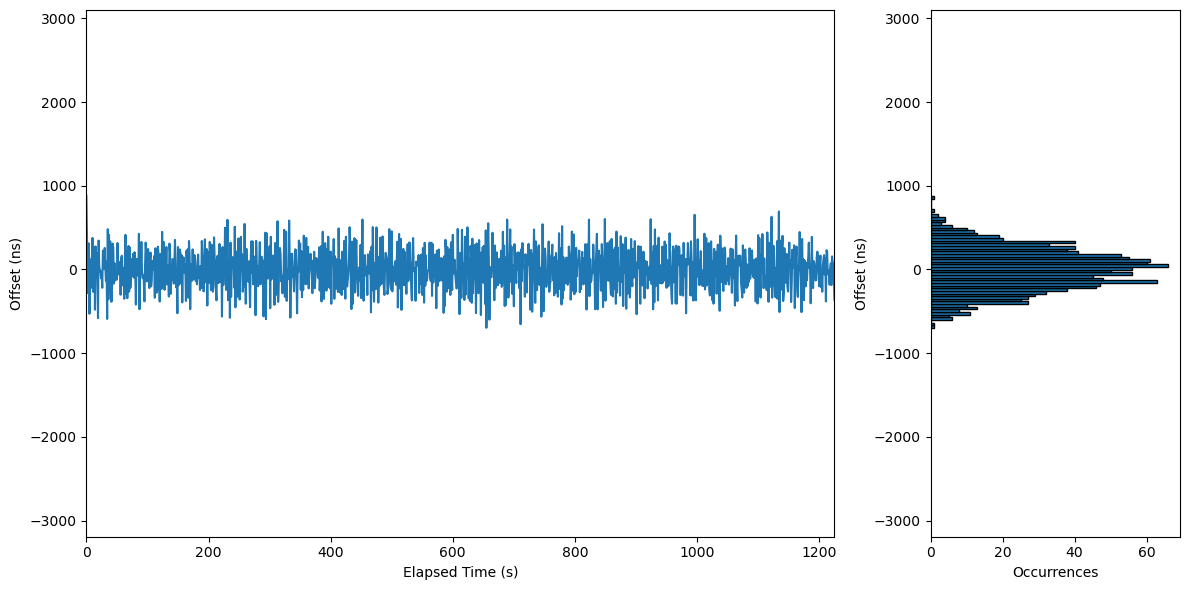

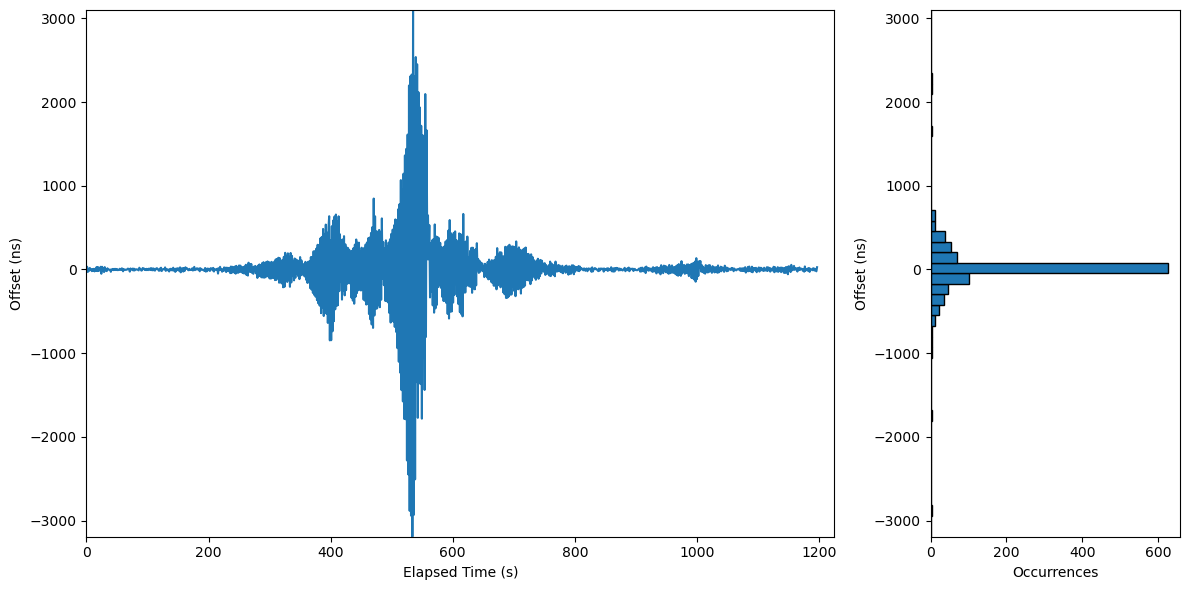

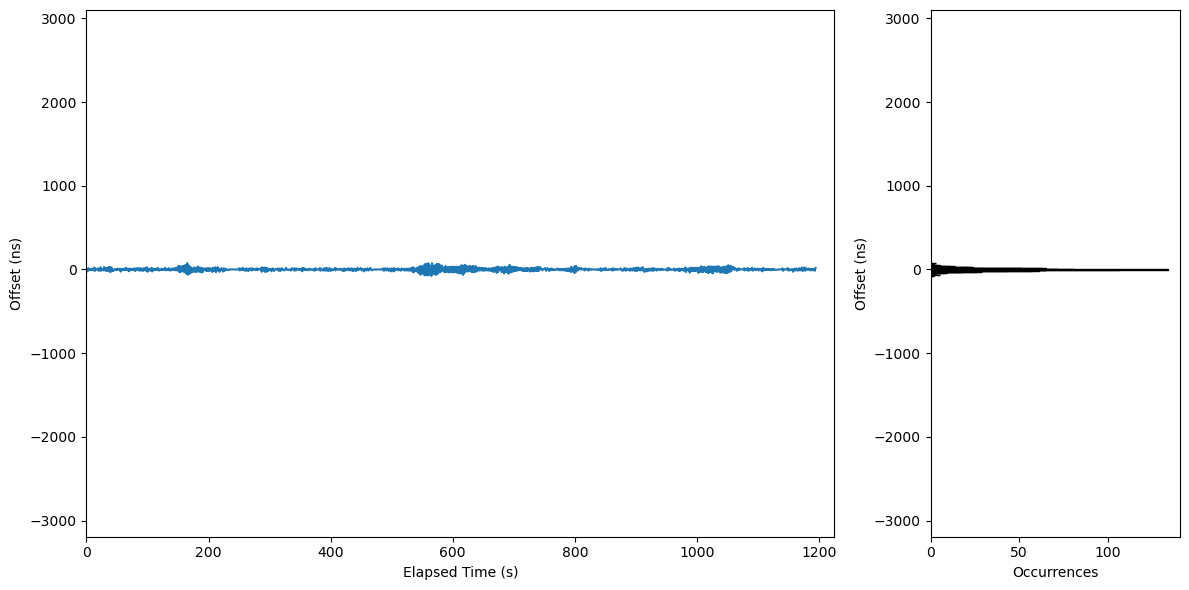

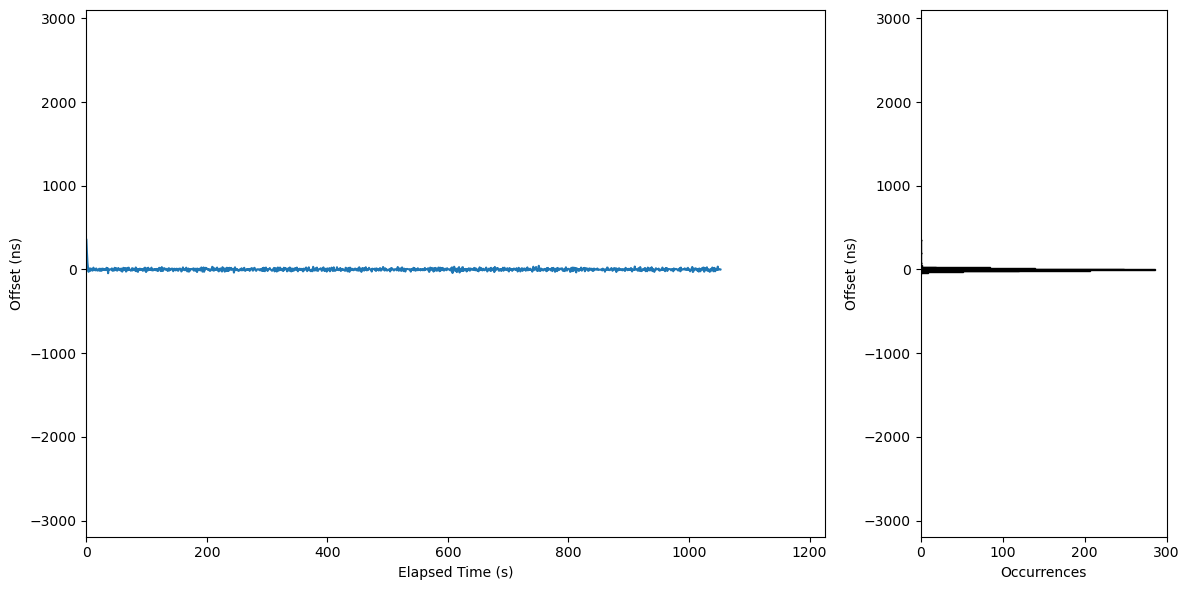

In [20]:
# Primeiro, determina os limites globais
for log_file in log_files:
    df = process_log_file(log_file)
    global_min_seconds = min(global_min_seconds, df['seconds'].min())
    global_max_seconds = max(global_max_seconds, df['seconds'].max())
    global_min_offset = min(global_min_offset, df['offset'].min())
    global_max_offset = max(global_max_offset, df['offset'].max())

# Então, plota cada gráfico com os limites globais
for log_file in log_files:
    df = process_log_file(log_file)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    ax1.plot(df['seconds'], df['offset'])
    ax1.set(xlabel='Elapsed Time (s)', ylabel='Offset (ns)')
    ax1.set_xlim(global_min_seconds, global_max_seconds)
    ax1.set_ylim(global_min_offset, global_max_offset)
    
    ax2.hist(df['offset'], bins=50, orientation='horizontal', edgecolor='black')
    ax2.set(ylabel='Offset (ns)', xlabel='Occurrences')
    ax2.set_ylim(ax1.get_ylim())
    
    plt.tight_layout()
    
    base_name = os.path.basename(log_file)
    plot_file_name = f'plots/{base_name}_marginal_plot.png'
    
    plt.savefig(plot_file_name, format='png', bbox_inches='tight')
    plt.show()

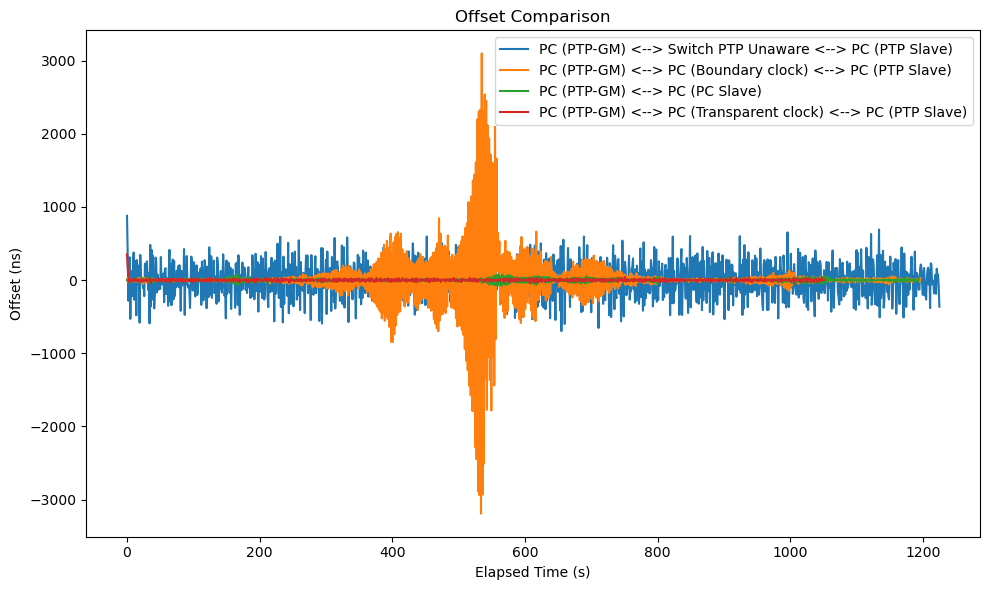

In [23]:
plt.figure(figsize=(10, 6))

file_label_mapping = {
    'lasse100Master_jv3301Slave.txt': 'PC (PTP-GM) <--> PC (PC Slave)',
    'NG4_lasse100Master_jv3301Slave.txt': 'PC (PTP-GM) <--> Switch PTP Unaware <--> PC (PTP Slave)',
    'slaveside_jv3301Master_lasse100TC_VostroSlave.txt': 'PC (PTP-GM) <--> PC (Transparent clock) <--> PC (PTP Slave)',
    'VostroMaster_lasse100bc_jv3301slave.txt': 'PC (PTP-GM) <--> PC (Boundary clock) <--> PC (PTP Slave)',
}

for log_file in log_files:
    df = process_log_file(log_file)
    file_name = os.path.basename(log_file)
    label = file_label_mapping.get(file_name, file_name)
    plt.plot(df['seconds'], df['offset'], label=label)

plt.xlabel('Elapsed Time (s)')
plt.ylabel('Offset (ns)')
plt.title('Offset Comparison')
plt.legend()
plt.tight_layout()

plt.show()